In [5]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from tqdm import tqdm
from collections import Counter


# Verificar versión de TensorFlow
print("Versión de TensorFlow:", tf.__version__)

Versión de TensorFlow: 2.19.0


# **Ejercicio 1: Descarga y exploración del dataset**

### **Trabajo en código:**

#### Descargue el dataset desde Kaggle: Male and Female Faces Dataset (Ashwin Gupta), organice las carpetas en data/male/ y data/female/ y Verifique el número de imágenes por clase.

In [3]:
def cargar_dataset(base_dir, img_size=(224, 224)):
    """
    Lee imágenes desde:
      base_dir/Male Faces  -> etiqueta 0
      base_dir/Female Faces -> etiqueta 1
    Convierte a RGB, redimensiona y normaliza a [0,1].
    Retorna X (numpy float32, N x H x W x 3) y y (numpy int).
    """
    male_dir = os.path.join(base_dir, "Male Faces")
    female_dir = os.path.join(base_dir, "Female Faces")
    if not os.path.isdir(male_dir) or not os.path.isdir(female_dir):
        raise FileNotFoundError(f"No se encontraron las carpetas esperadas en {base_dir}")

    X, y = [], []
    for label, folder in [(0, male_dir), (1, female_dir)]:
        for fname in tqdm(os.listdir(folder), desc=f"Leyendo {os.path.basename(folder)}"):
            fpath = os.path.join(folder, fname)
            try:
                with Image.open(fpath) as im:
                    im = im.convert("RGB").resize(img_size)
                    arr = np.array(im, dtype=np.float32) / 255.0
                    X.append(arr)
                    y.append(label)
            except Exception:
                # Ignorar archivos dañados o no imágenes
                continue

    if len(X) == 0:
        return np.empty((0, img_size[0], img_size[1], 3), dtype=np.float32), np.array([], dtype=np.int32)

    X = np.stack(X, axis=0)
    y = np.array(y, dtype=np.int32)
    return X, y

# Ejemplo de uso (ajusta la ruta si la tuya es distinta):
base = r"c:\Users\marin\Documents\Deep Learning\CNN\Male and Female face dataset"
X, y = cargar_dataset(base, img_size=(224, 224))
print("X.shape:", X.shape, "y.shape:", y.shape)
print("Recuento por clase:", np.unique(y, return_counts=True))
# ...existing code...

Leyendo Female Faces:  29%|██▉       | 795/2698 [01:19<03:12,  9.90it/s]c:\Users\marin\miniconda3\envs\tf_test\lib\site-packages\PIL\Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Leyendo Female Faces: 100%|██████████| 2698/2698 [03:37<00:00, 12.38it/s]


X.shape: (5418, 224, 224, 3) y.shape: (5418,)
Recuento por clase: (array([0, 1], dtype=int32), array([2720, 2698]))


#### Explore el tamaño y tipo de archivo de varias imágenes.

In [6]:
base_dir = r"c:\Users\marin\Documents\Deep Learning\CNN\Male and Female face dataset"
male_dir = os.path.join(base_dir, "Male Faces")
female_dir = os.path.join(base_dir, "Female Faces")

def explorar_carpeta(folder, muestra=5):
    print(f"\n--- Explorando: {folder} ---")
    if not os.path.isdir(folder):
        print("Carpeta no encontrada:", folder)
        return

    archivos = sorted(os.listdir(folder))
    print(f"Total archivos: {len(archivos)}")
    # Mostrar ejemplo de primeros archivos
    for fname in archivos[:muestra]:
        path = os.path.join(folder, fname)
        try:
            size_bytes = os.path.getsize(path)
            with Image.open(path) as im:
                print(f"- {fname} | ext: {os.path.splitext(fname)[1].lower()} | bytes: {size_bytes:,} | tamaño: {im.size} | formato: {im.format} | modo: {im.mode}")
        except Exception as e:
            print(f"- {fname} -> ERROR al abrir ({e})")

    # Resumen por extensión y por resolución
    ext_counter = Counter()
    res_counter = Counter()
    errores = 0
    for fname in archivos:
        path = os.path.join(folder, fname)
        ext_counter[os.path.splitext(fname)[1].lower()] += 1
        try:
            with Image.open(path) as im:
                res_counter[im.size] += 1
        except Exception:
            errores += 1

    print("\nResumen por extensión:", dict(ext_counter))
    top_res = res_counter.most_common(5)
    print("Resoluciones más comunes (top 5):", top_res)
    if errores:
        print("Archivos que no se pudieron leer:", errores)

# Ejecutar exploración para ambas carpetas
explorar_carpeta(male_dir, muestra=5)
explorar_carpeta(female_dir, muestra=5)


--- Explorando: c:\Users\marin\Documents\Deep Learning\CNN\Male and Female face dataset\Male Faces ---
Total archivos: 2720
- 1 (1).jpeg | ext: .jpeg | bytes: 281,118 | tamaño: (1066, 1600) | formato: JPEG | modo: RGB
- 1 (1).jpg | ext: .jpg | bytes: 34,799 | tamaño: (500, 750) | formato: JPEG | modo: RGB
- 1 (1).png | ext: .png | bytes: 623,702 | tamaño: (429, 527) | formato: PNG | modo: RGBA
- 1 (10).jpeg | ext: .jpeg | bytes: 71,948 | tamaño: (960, 1280) | formato: JPEG | modo: RGB
- 1 (10).jpg | ext: .jpg | bytes: 132,220 | tamaño: (961, 1200) | formato: JPEG | modo: RGB

Resumen por extensión: {'.jpeg': 21, '.jpg': 2643, '.png': 56}
Resoluciones más comunes (top 5): [((500, 750), 114), ((736, 1104), 69), ((736, 981), 34), ((640, 960), 32), ((600, 900), 30)]

--- Explorando: c:\Users\marin\Documents\Deep Learning\CNN\Male and Female face dataset\Female Faces ---
Total archivos: 2698
- 0 (1).jpeg | ext: .jpeg | bytes: 2,628,631 | tamaño: (3539, 5309) | formato: JPEG | modo: RGB
- 0

#### Visualice ejemplos de ambas clases para confirmar la correcta lectura.

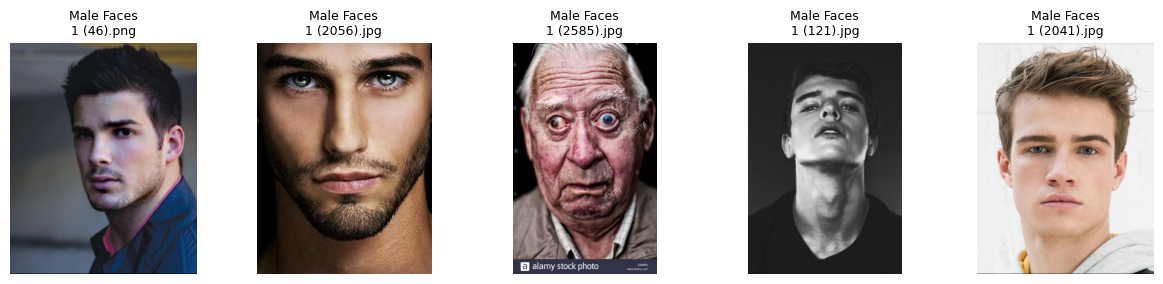

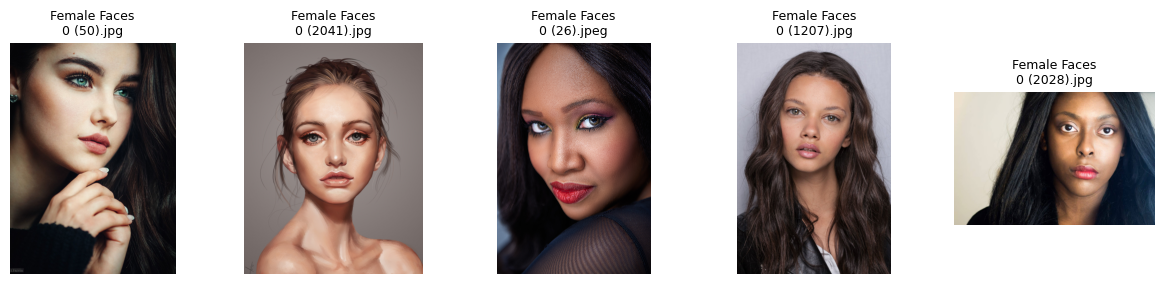

In [8]:
def mostrar_ejemplos(folder, title, n=5, seed=42):
    files = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
    rng = np.random.default_rng(seed)
    if len(files) == 0:
        print("Carpeta vacía:", folder)
        return
    sel = files if len(files) <= n else list(rng.choice(files, size=n, replace=False))
    plt.figure(figsize=(3 * len(sel), 3))
    for i, fname in enumerate(sel):
        path = os.path.join(folder, fname)
        try:
            img = Image.open(path).convert("RGB")
            plt.subplot(1, len(sel), i + 1)
            plt.imshow(img)
            plt.axis("off")
            plt.title(f"{title}\n{fname}", fontsize=9)
        except Exception as e:
            plt.subplot(1, len(sel), i + 1)
            plt.text(0.5, 0.5, "ERROR\n" + str(e), ha="center")
            plt.axis("off")
    plt.show()


SEED = 42

# Mostrar 5 ejemplos aleatorios por clase
mostrar_ejemplos(male_dir, "Male Faces", n=5, seed=SEED)
mostrar_ejemplos(female_dir, "Female Faces", n=5, seed=SEED)

# **Ejercicio 2: Preprocesamiento y partición**

## **Trabajo en código:**

#### Implemente la carga del dataset asegurando que todas las imágenes se mantengan en color (RGB) y Redimensione todas las imágenes a un tamaño uniforme (por ejemplo, 224x224 píxeles).


In [9]:
# Parámetros generales
IMG_SIZE = (224, 224)
SEED = 42

def cargar_imagenes_y_etiquetas(male_dir, female_dir, img_size=(224, 224)):
    X, y = [], []

    # Clase 0 = male
    for file in tqdm(os.listdir(male_dir), desc="Cargando hombres"):
        path = os.path.join(male_dir, file)
        try:
            img = Image.open(path).convert("RGB")  # Asegurar color
            img = img.resize(img_size)
            X.append(np.array(img))
            y.append(0)
        except:
            continue

    # Clase 1 = female
    for file in tqdm(os.listdir(female_dir), desc="Cargando mujeres"):
        path = os.path.join(female_dir, file)
        try:
            img = Image.open(path).convert("RGB")
            img = img.resize(img_size)
            X.append(np.array(img))
            y.append(1)
        except:
            continue

    return np.array(X), np.array(y)

X, y = cargar_imagenes_y_etiquetas(male_dir, female_dir, IMG_SIZE)
print(f"\n Dataset cargado correctamente: {X.shape[0]} imágenes totales.")

Cargando mujeres:  29%|██▉       | 794/2698 [00:32<04:27,  7.13it/s]c:\Users\marin\miniconda3\envs\tf_test\lib\site-packages\PIL\Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Cargando mujeres: 100%|██████████| 2698/2698 [02:06<00:00, 21.31it/s]



 Dataset cargado correctamente: 5418 imágenes totales.


### Normalice los valores de los píxeles en el rango [0,1].

In [10]:
def normalizar_X(X):
    """Normaliza X a float32 en [0,1]. Si ya está en [0,1] no divide de nuevo."""
    if X is None:
        raise ValueError("X es None")
    if getattr(X, "size", 0) == 0:
        return X.astype(np.float32)
    X = X.astype(np.float32)
    # Si los valores ya están en [0,1] (máx <= 1.0) no dividir
    if X.max() > 1.0:
        X = X / 255.0
    return X

# Ejecutar después de cargar X (por ejemplo tras cargar_imagenes_y_etiquetas o cargar_dataset_rgb)
X = normalizar_X(X)
print("Normalización completada. dtype:", X.dtype, "min:", X.min(), "max:", X.max())

Normalización completada. dtype: float32 min: 0.0 max: 1.0


#### Divida el conjunto en entrenamiento, validación y prueba (por ejemplo, 70/15/15) con una semilla fija.

In [11]:
# Primero: train (70%) y temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=SEED, stratify=y)

# Luego: valid (15%) y test (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=SEED, stratify=y_temp)

print(f"\n Tamaños de los subconjuntos:")
print(f"Entrenamiento: {X_train.shape[0]} imágenes ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validación: {X_val.shape[0]} imágenes ({len(X_val)/len(X)*100:.1f}%)")
print(f"Prueba: {X_test.shape[0]} imágenes ({len(X_test)/len(X)*100:.1f}%)")

# ------------------------------------------------------
# 4️⃣ Verificar estructura final
# ------------------------------------------------------
print("\n Formas de los conjuntos:")
print("X_train:", X_train.shape, " y_train:", y_train.shape)
print("X_val:", X_val.shape, " y_val:", y_val.shape)
print("X_test:", X_test.shape, " y_test:", y_test.shape)


 Tamaños de los subconjuntos:
Entrenamiento: 3792 imágenes (70.0%)
Validación: 813 imágenes (15.0%)
Prueba: 813 imágenes (15.0%)

 Formas de los conjuntos:
X_train: (3792, 224, 224, 3)  y_train: (3792,)
X_val: (813, 224, 224, 3)  y_val: (813,)
X_test: (813, 224, 224, 3)  y_test: (813,)


# **Ejercicio 3: Construcción y entrenamiento del modelo CNN**

### **Trabajo en código:**

#### Construya una CNN secuencial con al menos tres bloques Conv2D + MaxPooling2D, seguidos de capas densas y use funciones de activación ReLU y una salida sigmoide (Dense(1, activation=sigmoide)).


In [25]:
# --- 1. Definir la arquitectura de la CNN ---
model = Sequential([
    # Bloque 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),

    # Bloque 2
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Bloque 3
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Aplanamiento y capas densas
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # para reducir sobreajuste
    Dense(1, activation='sigmoid')  # salida binaria: male/female
])

model.summary()



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

### Compile el modelo con binary crossentropy y el optimizador Adam.


In [13]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

### Entrene el modelo y registre las métricas de exactitud y pérdida.

In [14]:
history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_data=(X_val, y_val)
)

Epoch 1/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 82s 647ms/step - accuracy: 0.6875 - loss: 0.5817 - val_accuracy: 0.8241 - val_loss: 0.4224
Epoch 2/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 76s 639ms/step - accuracy: 0.8726 - loss: 0.3114 - val_accuracy: 0.9077 - val_loss: 0.2128
Epoch 3/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 74s 625ms/step - accuracy: 0.9441 - loss: 0.1544 - val_accuracy: 0.9594 - val_loss: 0.1277
Epoch 4/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.9713 - loss: 0.0830 - val_accuracy: 0.9742 - val_loss: 0.0894
Epoch 5/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.9855 - loss: 0.0515 - val_accuracy: 0.9828 - val_loss: 0.0827
Epoch 6/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.9937 - loss: 0.0220 - val_accuracy: 0.9902 - val_loss: 0.0825
Epoch 7/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.9937 - loss: 0.0212 - val_accuracy: 0.9840 - val_loss: 0.0864
Epoch 8/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 72s 606ms/step - accuracy: 0.9921 - loss: 0.0314 - 

In [15]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"\nExactitud en test: {test_acc:.4f}")
print(f"Pérdida en test: {test_loss:.4f}")

26/26 - 4s - 142ms/step - accuracy: 0.9828 - loss: 0.1547

Exactitud en test: 0.9828
Pérdida en test: 0.1547


26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step
              precision    recall  f1-score   support

           0     0.9950    0.9706    0.9826       408
           1     0.9711    0.9951    0.9829       405

    accuracy                         0.9828       813
   macro avg     0.9830    0.9828    0.9828       813
weighted avg     0.9831    0.9828    0.9828       813

AUC: 0.9939


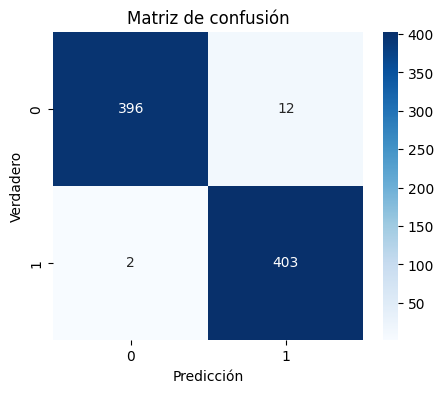

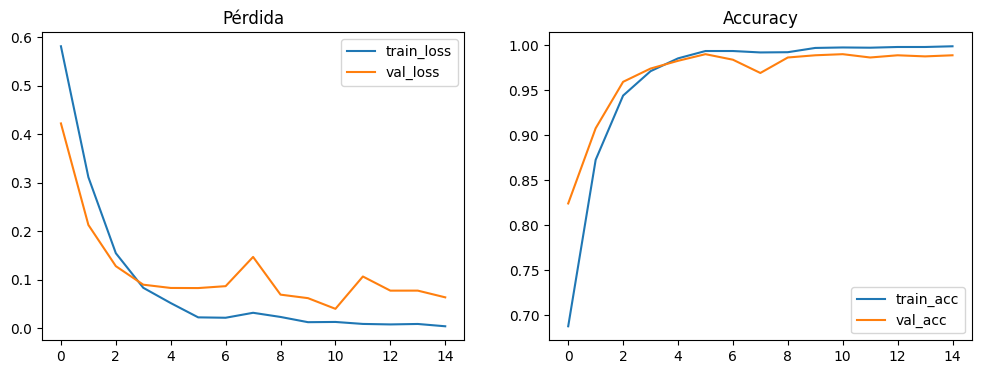

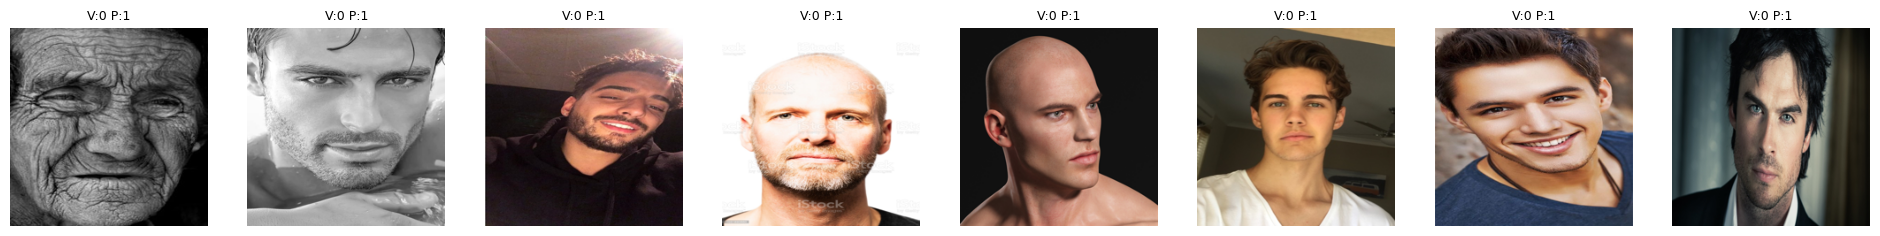

In [19]:
# Evaluación detallada: reporte, AUC, matriz de confusión, curvas y malas clasificaciones
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Comprobaciones básicas
for var in ("model", "X_test", "y_test"):
    if var not in globals():
        raise NameError(f"'{var}' no está definido. Ejecuta las celdas previas que entrenan/modelan y cargan los datos.")

# Predicciones
probs = model.predict(X_test, batch_size=32)
y_pred = (probs.ravel() > 0.5).astype(int)

# Reporte de clasificación
print(classification_report(y_test, y_pred, digits=4))

# AUC (si procede)
try:
    auc = roc_auc_score(y_test, probs.ravel())
    print(f"AUC: {auc:.4f}")
except Exception:
    pass

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Matriz de confusión')
plt.show()

# Curvas de entrenamiento
if 'history' in globals() and hasattr(history, 'history'):
    h = history.history
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    if 'loss' in h and 'val_loss' in h:
        plt.plot(h['loss'], label='train_loss')
        plt.plot(h['val_loss'], label='val_loss')
        plt.legend(); plt.title('Pérdida')
    plt.subplot(1,2,2)
    if 'accuracy' in h and 'val_accuracy' in h:
        plt.plot(h['accuracy'], label='train_acc')
        plt.plot(h['val_accuracy'], label='val_acc')
        plt.legend(); plt.title('Accuracy')
    plt.show()
else:
    print("No se encontró 'history' con métricas para plotear.")

# Mostrar algunas malas clasificaciones
mis_idx = np.where(y_test != y_pred)[0]
if len(mis_idx) == 0:
    print("No hay malas clasificaciones en el conjunto de prueba.")
else:
    n_show = min(8, len(mis_idx))
    plt.figure(figsize=(3*n_show,3))
    for i, idx in enumerate(mis_idx[:n_show]):
        plt.subplot(1, n_show, i+1)
        img = X_test[idx]
        # si está normalizado en [0,1] convertir a uint8
        if img.max() <= 1.0:
            disp = (img * 255).astype(np.uint8)
        else:
            disp = img.astype(np.uint8)
        plt.imshow(disp)
        plt.title(f"V:{y_test[idx]} P:{y_pred[idx]}", fontsize=9)
        plt.axis('off')
    plt.show()

El CNN para clasificar imágenes de hombres y mujeres está funcionando muy bien.

### **🧠 1. Rendimiento general**

#### **Accuracy en test:** 0.9828

#### **AUC:** 0.9939

#### **Precision, recall y F1-score:** todos alrededor de 0.98

👉 Esto indica que el modelo distingue muy bien entre ambas clases, con un equilibrio perfecto entre sensibilidad y precisión.
👉 En la matriz de confusión (396 y 403 aciertos, 12 y 2 errores) hay muy pocos falsos positivos y falsos negativos, lo cual es señal de gran generalización.

### **📉 2. Curvas de pérdida y exactitud**

Tu gráfico muestra que la pérdida de entrenamiento y validación bajan rápido y se estabilizan, lo que sugiere entrenamiento estable.

No hay señales graves de sobreajuste (overfitting), aunque a partir de la época 6–8 parece que la val_loss deja de mejorar mucho, lo que podrías mejorar con un pequeño ajuste de hiperparámetros.

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step


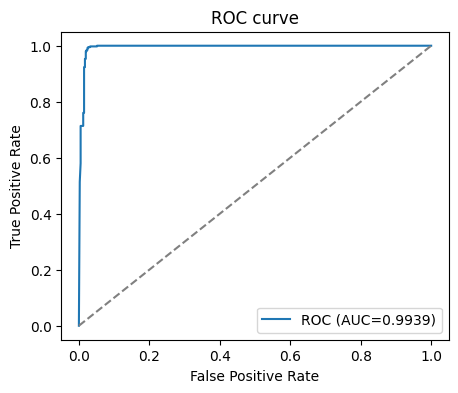

Malas clasificaciones: 14


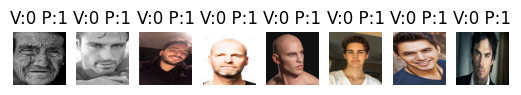

In [20]:
# ...existing code...
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# AUC / ROC
probs = model.predict(X_test, batch_size=32).ravel()
try:
    auc_score = roc_auc_score(y_test, probs)
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f'ROC (AUC={auc_score:.4f})')
    plt.plot([0,1],[0,1],'--',color='gray')
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title('ROC curve'); plt.legend(); plt.show()
except Exception as e:
    print('No se pudo calcular ROC/AUC:', e)

# Mostrar malas clasificaciones (imagenes)
y_pred = (probs > 0.5).astype(int)
mis_idx = np.where(y_test != y_pred)[0]
print('Malas clasificaciones:', len(mis_idx))
for i, idx in enumerate(mis_idx[:8]):
    plt.subplot(1, min(8,len(mis_idx)), i+1)
    img = X_test[idx]
    if img.max() <= 1.0:
        disp = (img * 255).astype(np.uint8)
    else:
        disp = img.astype(np.uint8)
    plt.imshow(disp); plt.title(f'V:{y_test[idx]} P:{y_pred[idx]}'); plt.axis('off')
plt.show()
# ...existing code...

#### Guarde el modelo entrenado en models/model.keras

In [21]:
# Asegurar carpeta models y guardar el modelo en formato .keras
os.makedirs("models", exist_ok=True)
save_path = os.path.join("models", "model.keras")
model.save(save_path)  # guarda en formato Keras (.keras)
print(f"Modelo guardado en: {save_path}")

Modelo guardado en: models\model.keras


# **Ejercicio 4: Ajuste de hiperparámetros**

## **Trabajo en código:**

#### Realice pequeños experimentos variando hiperparámetros (número de filtros, tamaño del kernel, tasa de aprendizaje o dropout) y compare el desempe ̃no de al menos dos configuraciones distintas.

#### **VARIANTE 1: CNN más profunda con Batch Normalization y Dropout**

In [24]:
# --- VARIANTE 1: CNN más profunda con Batch Normalization ---

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Definición del modelo
model_v1 = Sequential([
    # Bloque 1
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Bloque 2
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Bloque 3
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Bloque 4 adicional
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Capas densas
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compilación
model_v1.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

# Resumen del modelo
model_v1.summary()


c:\Users\marin\miniconda3\envs\tf_test\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,235,905 (50.49 MB)

 Trainable params: 13,234,945 (50.49 MB)

 Non-trainable params: 960 (3.75 KB)

In [28]:
# --- VARIANTE 2: CNN base + Data Augmentation + RMSprop ---

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation para entrenamiento
# --- Generadores de imágenes ---

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    X_train,    
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    X_val,       # ⚠️ cambia esta ruta
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)


# Arquitectura base (igual que tu modelo original)
model_v2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

# Compilación
model_v2.compile(optimizer=RMSprop(learning_rate=0.0003),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

ValueError: listdir: embedded null character in path